# **Importing library&function**






In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [4]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.90,0.05,0.05))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [01:00, 70.52 files/s] 

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 55 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 56 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 0 directories and 52 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 53 images in './outputgrayscale/test/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 966 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 989 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 915 images in './outputgrayscale/train/gray_glaucoma'.
There are 0 directories and 943 images in './outputgrayscale/train/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 53 images in './outputgrayscale/val/g

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [6]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [7]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

# **Batch size: 16**

In [8]:
epoch = 20
batchsize = 16

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [10]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 0s 0us/step


In [11]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                             

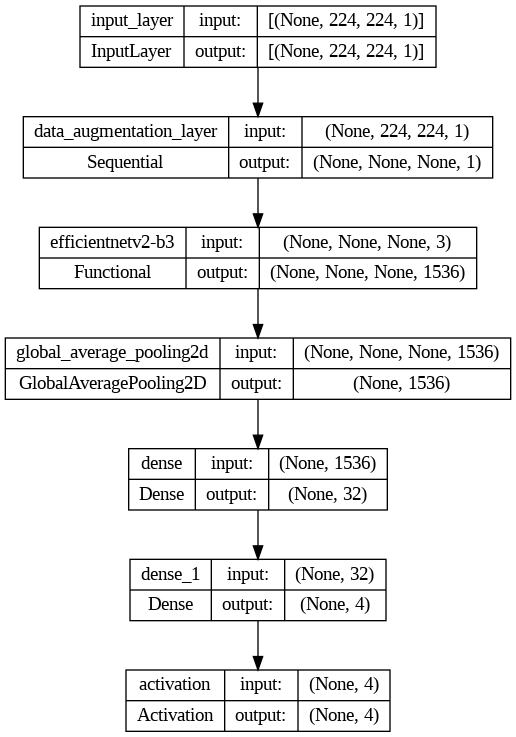

In [12]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [13]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [14]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 83s 269ms/step - loss: 0.7021 - accuracy: 0.7118 - val_loss: 0.6552 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 50s 209ms/step - loss: 0.5669 - accuracy: 0.7797 - val_loss: 0.6530 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 44s 185ms/step - loss: 0.5287 - accuracy: 0.7941 - val_loss: 0.5859 - val_accuracy: 0.7990 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 41s 172ms/step - loss: 0.4912 - accuracy: 0.8041 - val_loss: 0.5631 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 36s 150ms/step - loss: 0.5170 - accuracy: 0.7999 - val_loss: 0.5113 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 33s 137ms/step - loss: 0.4566 - accuracy: 0.8272 - val_loss: 0.4769 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

EfficientNetV2B3 Evaluation

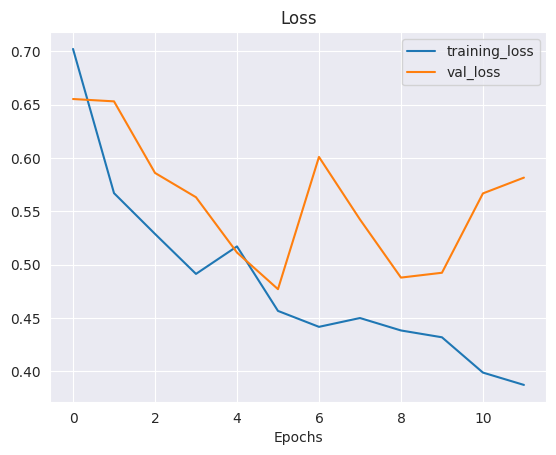

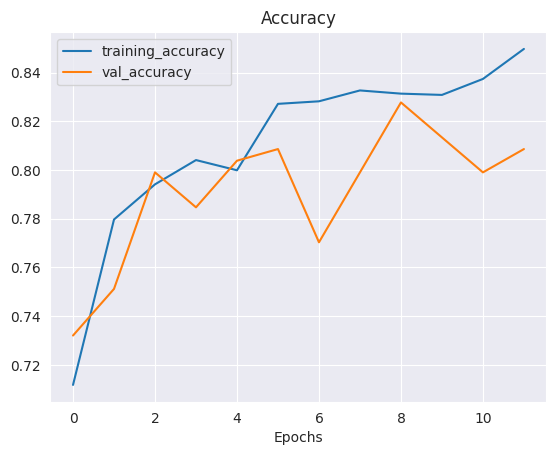

In [15]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 42ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        53
           1       0.80      0.93      0.86        56
           2       0.93      0.50      0.65        52
           3       0.68      0.82      0.74        55

    accuracy                           0.80       216
   macro avg       0.82      0.79      0.79       216
weighted avg       0.82      0.80      0.79       216

Specificity: [0.2934131736526946, 0.3170731707317073, 0.1368421052631579, 0.2631578947368421]
Mean Squared Error: : 0.12780550122261047
The average AUC-ROC is 0.9548326143850907


[0.9748427672955975,
 0.6490066225165563,
 0.7287234042553191,
 0.66,
 0.6477987421383647,
 0.9735099337748344,
 0.7021276595744681,
 0.6533333333333333,
 0.7169811320754716,
 0.6821192052980133,
 0.8617021276595744,
 0.7533333333333333,
 0.660377358490566,
 0.695364238410596,
 0.7074468085106383,
 0.9333333333333333]

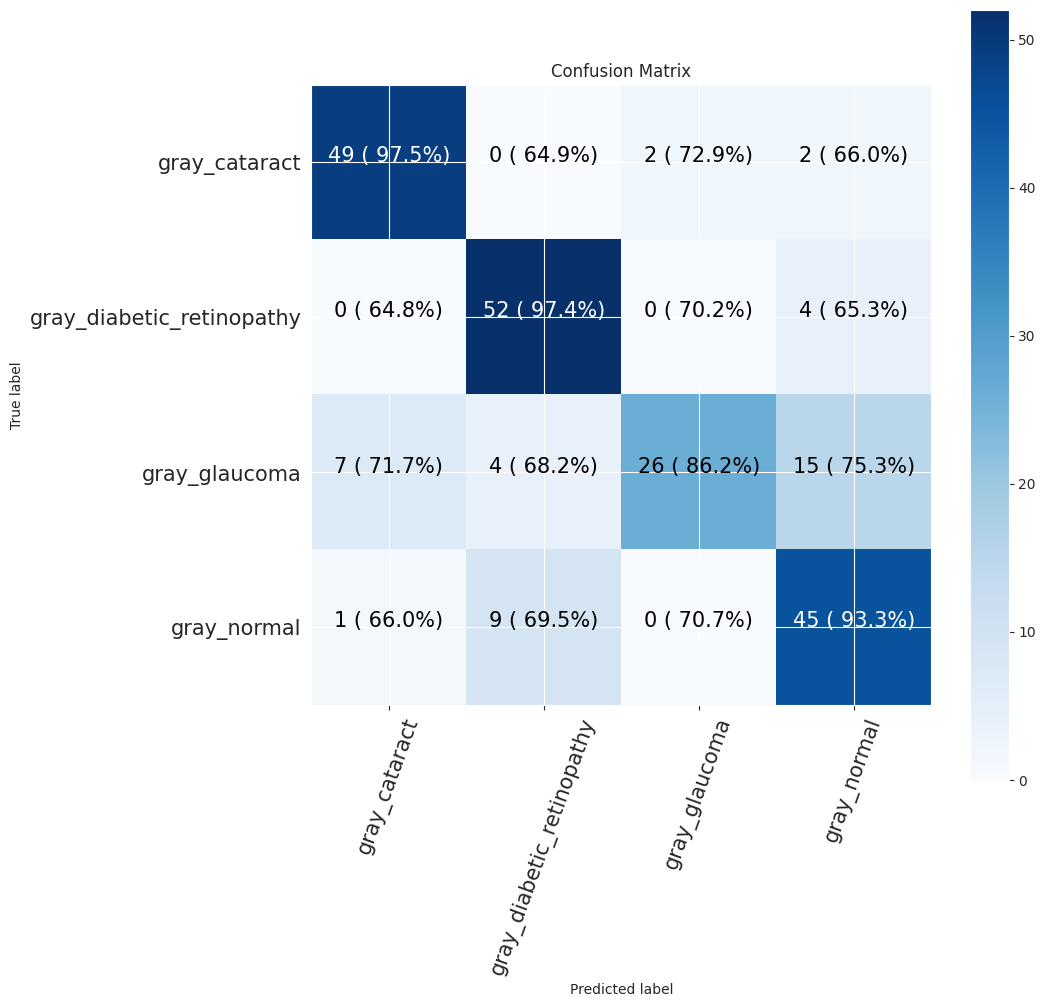

In [16]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


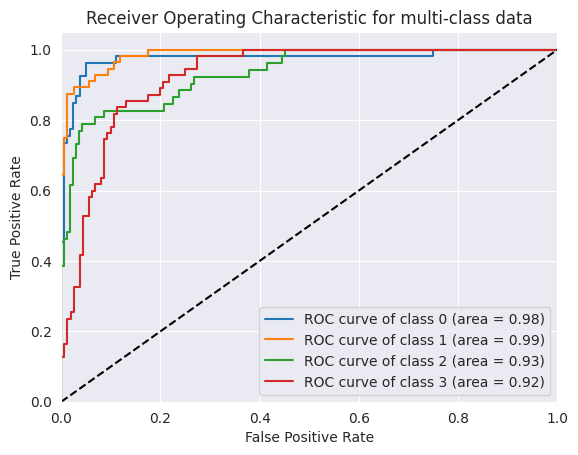

In [17]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [18]:

from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

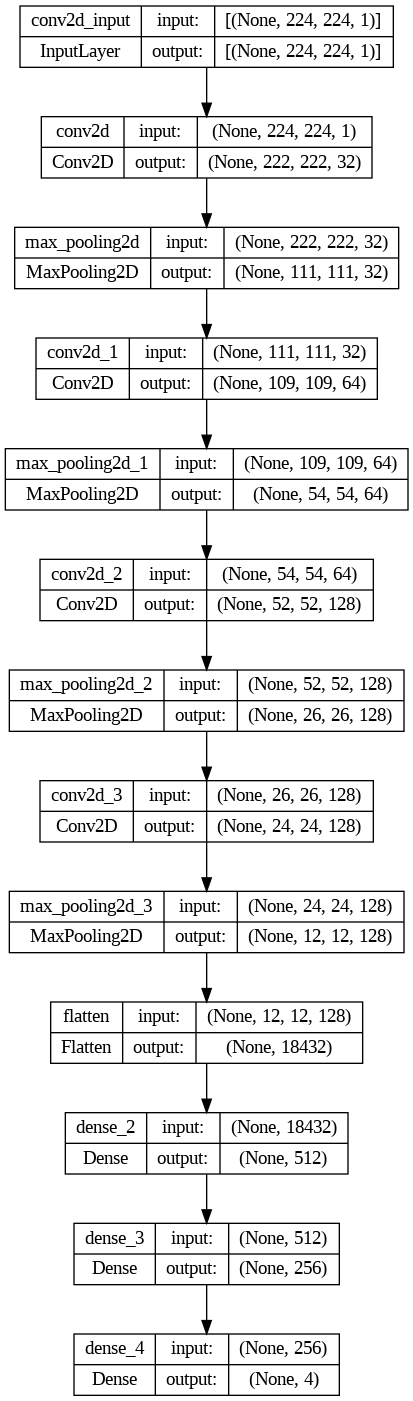

In [19]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [20]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [21]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 9s 22ms/step - loss: 2.0344 - accuracy: 0.5966 - val_loss: 0.6760 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 5s 20ms/step - loss: 0.6587 - accuracy: 0.6916 - val_loss: 0.6394 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 5s 20ms/step - loss: 0.6144 - accuracy: 0.7207 - val_loss: 0.5964 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 5s 20ms/step - loss: 0.5911 - accuracy: 0.7280 - val_loss: 0.5917 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 5s 20ms/step - loss: 0.5724 - accuracy: 0.7307 - val_loss: 0.7621 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 5s 20ms/step - loss: 0.5683 - accuracy: 0.7393 - val_loss: 0.5617 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 7/20
239/239 [==============================] - 5s 20ms/st

CNN Evaluation

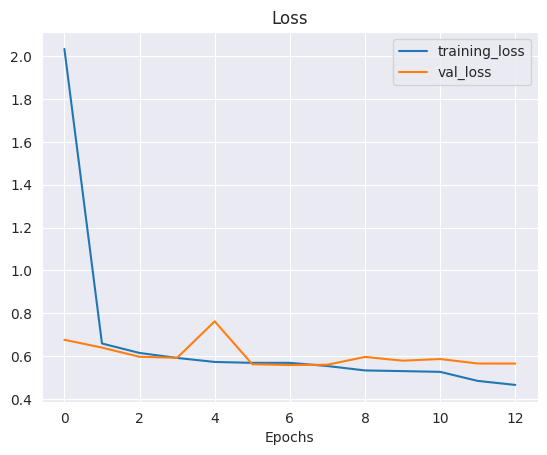

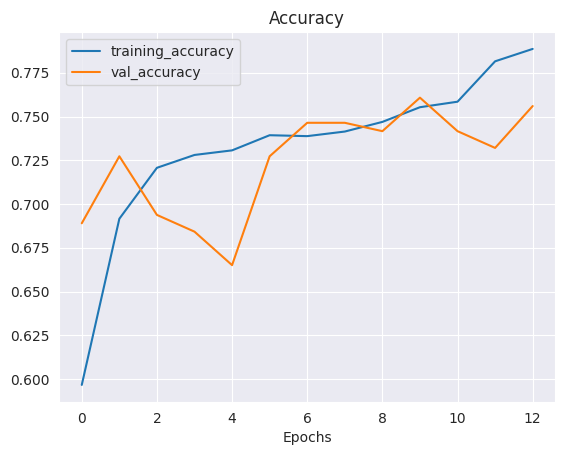

In [22]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.49      0.57        53
           1       1.00      1.00      1.00        56
           2       0.55      0.54      0.54        52
           3       0.72      0.93      0.81        55

    accuracy                           0.75       216
   macro avg       0.74      0.74      0.73       216
weighted avg       0.74      0.75      0.74       216

Specificity: [0.1368421052631579, 0.35, 0.14893617021276595, 0.3090909090909091]
Mean Squared Error: : 0.13426731526851654
The average AUC-ROC is 0.9119238123873841


[0.848314606741573,
 0.66875,
 0.8,
 0.6827586206896552,
 0.6853932584269663,
 1.0,
 0.6606060606060606,
 0.6137931034482759,
 0.7696629213483146,
 0.675,
 0.8545454545454545,
 0.7310344827586207,
 0.6966292134831461,
 0.65625,
 0.6848484848484848,
 0.9724137931034482]

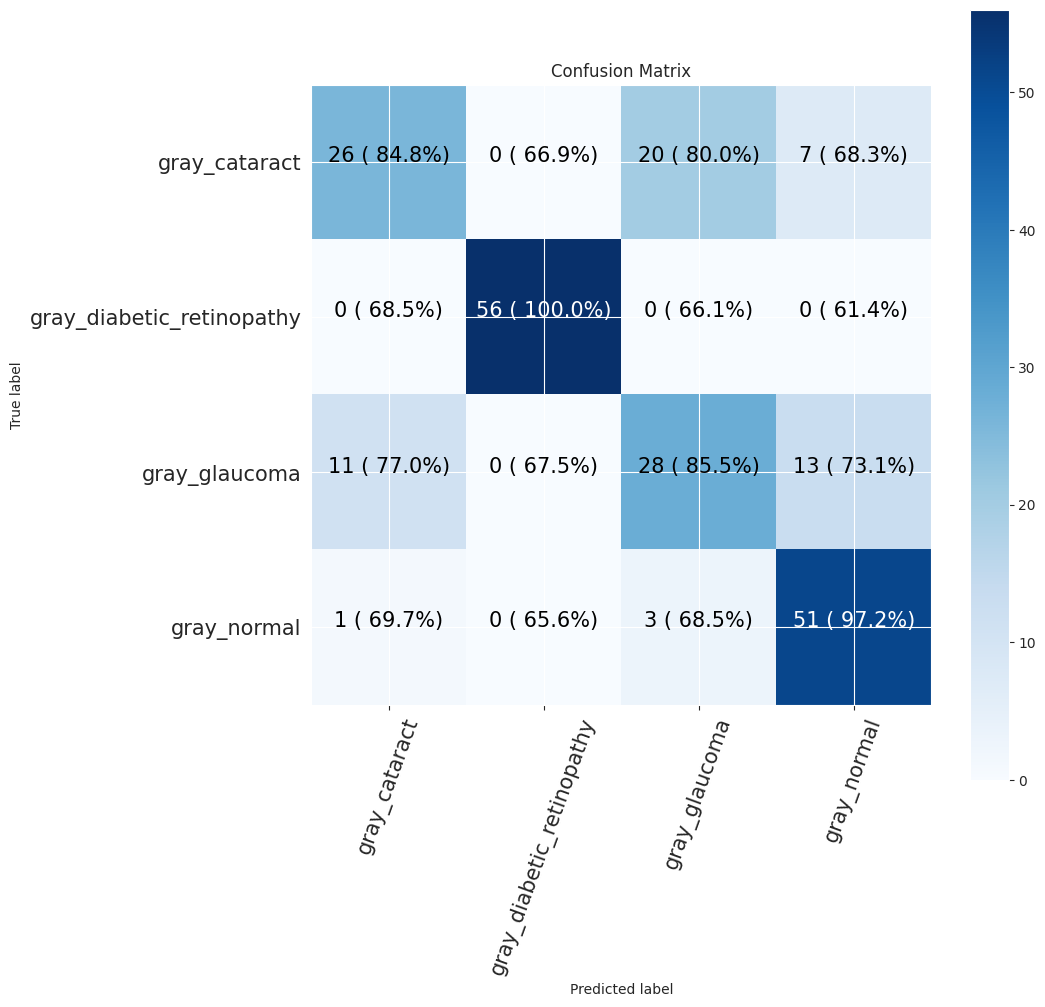

In [23]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


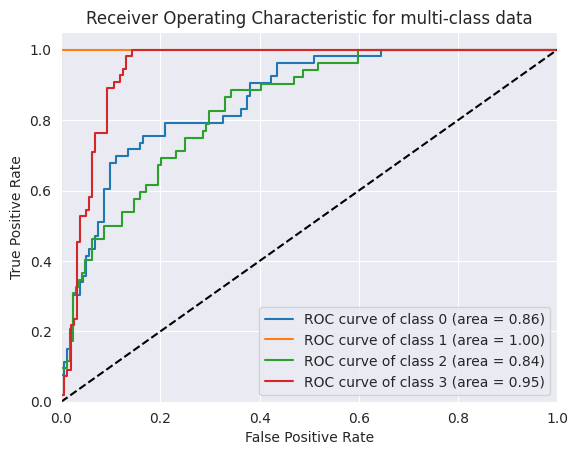

In [24]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [25]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 4)                 4100 

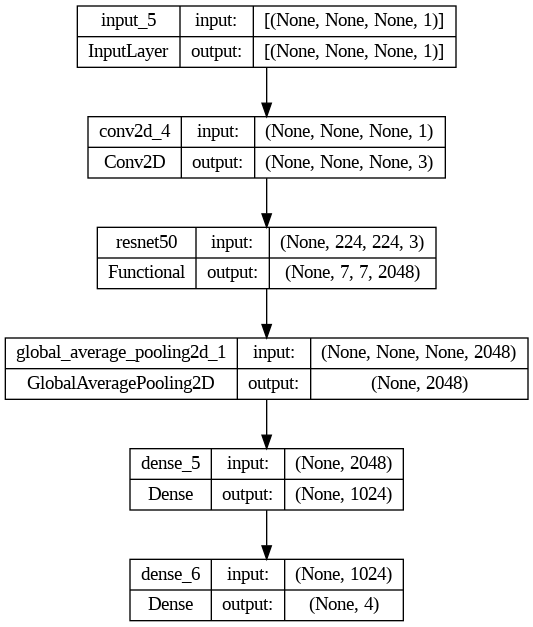

In [26]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [27]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [28]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 39s 141ms/step - loss: 0.6714 - accuracy: 0.7695 - val_loss: 0.4270 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 32s 133ms/step - loss: 0.3707 - accuracy: 0.8542 - val_loss: 0.3353 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 31s 131ms/step - loss: 0.3042 - accuracy: 0.8851 - val_loss: 0.3463 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 32s 132ms/step - loss: 0.3011 - accuracy: 0.8809 - val_loss: 0.3339 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 32s 132ms/step - loss: 0.2527 - accuracy: 0.8988 - val_loss: 0.3087 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 32s 132ms/step - loss: 0.2516 - accuracy: 0.9017 - val_loss: 0.3347 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet50 Evaluation

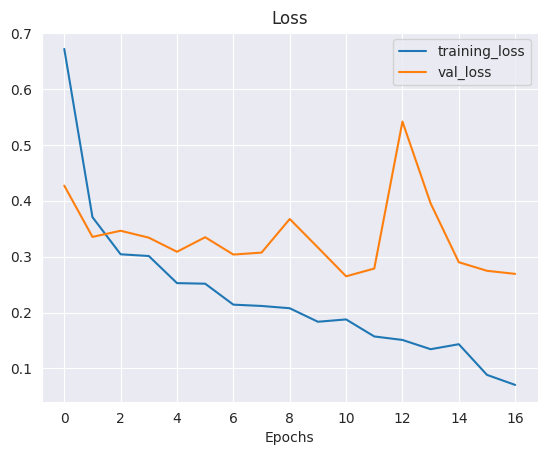

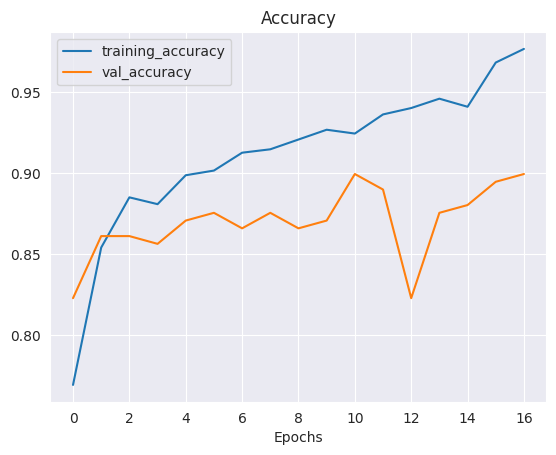

In [29]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        53
           1       1.00      1.00      1.00        56
           2       0.90      0.87      0.88        52
           3       0.88      0.93      0.90        55

    accuracy                           0.93       216
   macro avg       0.93      0.93      0.93       216
weighted avg       0.93      0.93      0.93       216

Specificity: [0.2934131736526946, 0.35, 0.2631578947368421, 0.3090909090909091]
Mean Squared Error: : 0.10455016791820526
The average AUC-ROC is 0.9904653170272015


[0.975609756097561,
 0.66875,
 0.6927710843373494,
 0.6772151898734177,
 0.6585365853658537,
 1.0,
 0.6626506024096386,
 0.6455696202531646,
 0.6951219512195121,
 0.675,
 0.9578313253012049,
 0.7025316455696202,
 0.6707317073170732,
 0.65625,
 0.6867469879518072,
 0.9746835443037974]

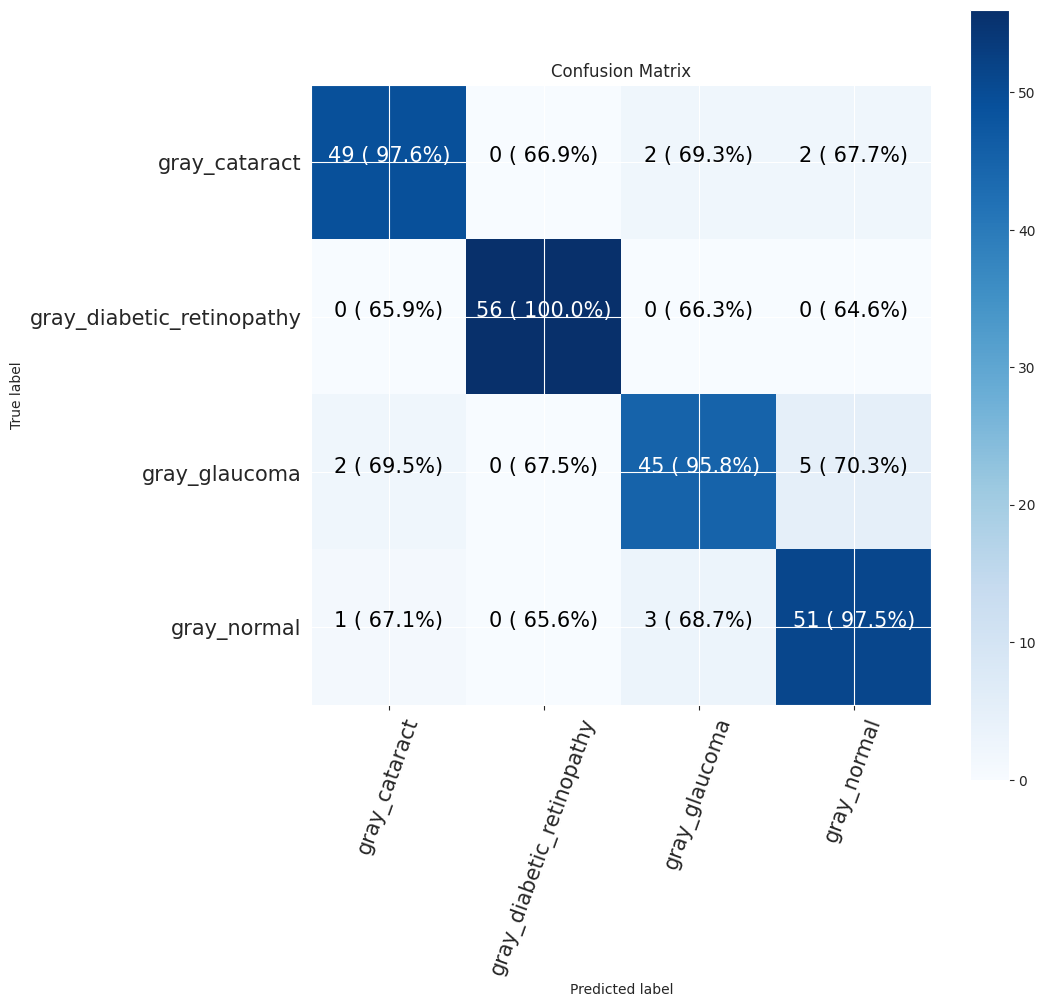

In [30]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


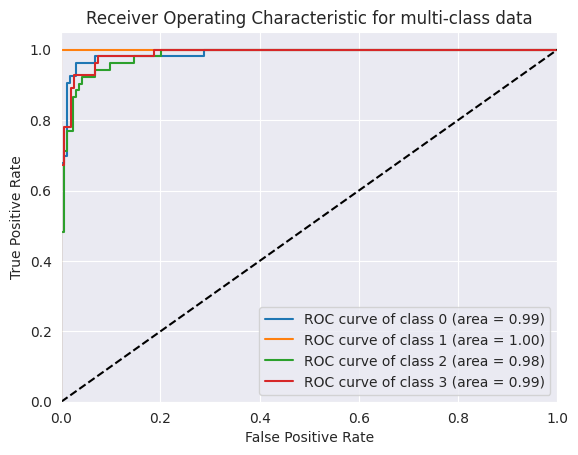

In [31]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [32]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 410

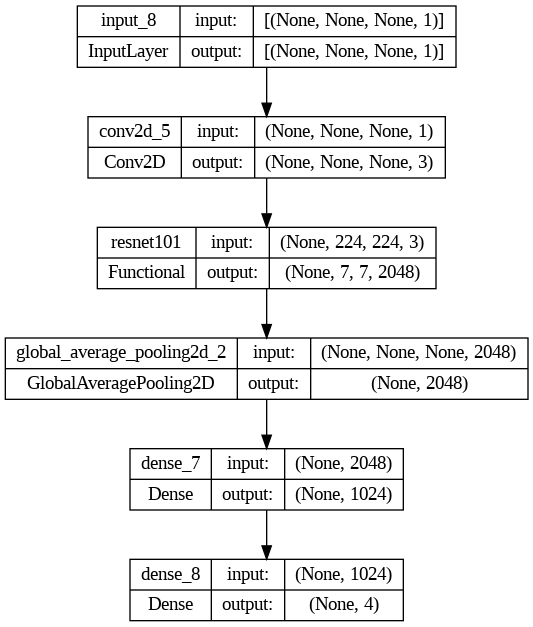

In [33]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [34]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [35]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 61s 226ms/step - loss: 0.6363 - accuracy: 0.7805 - val_loss: 0.6024 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 52s 216ms/step - loss: 0.3882 - accuracy: 0.8458 - val_loss: 0.3243 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 52s 217ms/step - loss: 0.3339 - accuracy: 0.8699 - val_loss: 0.3511 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 52s 216ms/step - loss: 0.2994 - accuracy: 0.8767 - val_loss: 0.4018 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 52s 217ms/step - loss: 0.2642 - accuracy: 0.9019 - val_loss: 0.3078 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 52s 217ms/step - loss: 0.2414 - accuracy: 0.9061 - val_loss: 0.3687 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet101 Evaluation

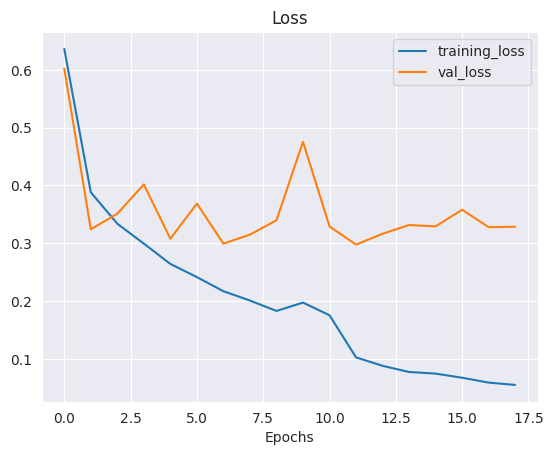

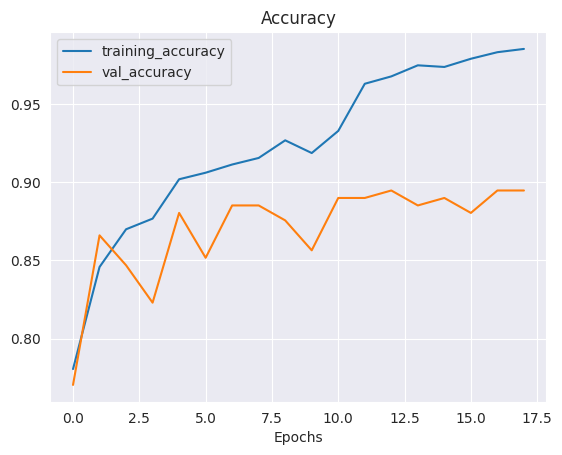

In [36]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 81ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        53
           1       1.00      0.98      0.99        56
           2       0.86      0.81      0.83        52
           3       0.88      0.91      0.89        55

    accuracy                           0.90       216
   macro avg       0.90      0.90      0.90       216
weighted avg       0.90      0.90      0.90       216

Specificity: [0.2857142857142857, 0.3416149068322981, 0.2413793103448276, 0.30120481927710846]
Mean Squared Error: : 0.10813553631305695
The average AUC-ROC is 0.9861465113597583


[0.968944099378882,
 0.6708074534161491,
 0.7065868263473054,
 0.6729559748427673,
 0.6521739130434783,
 0.9937888198757764,
 0.6646706586826348,
 0.6540880503144654,
 0.7080745341614907,
 0.6770186335403726,
 0.9401197604790419,
 0.7044025157232704,
 0.6708074534161491,
 0.6583850931677019,
 0.688622754491018,
 0.9685534591194969]

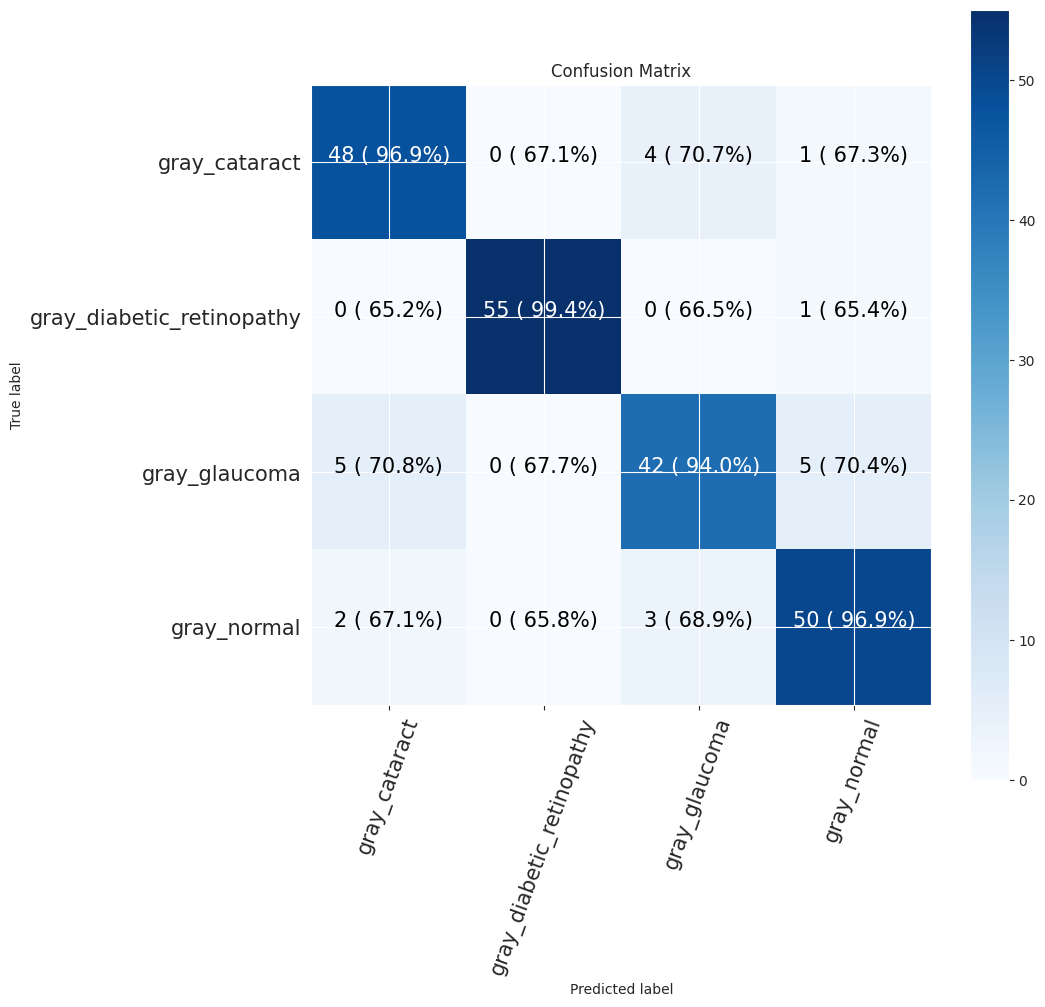

In [37]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


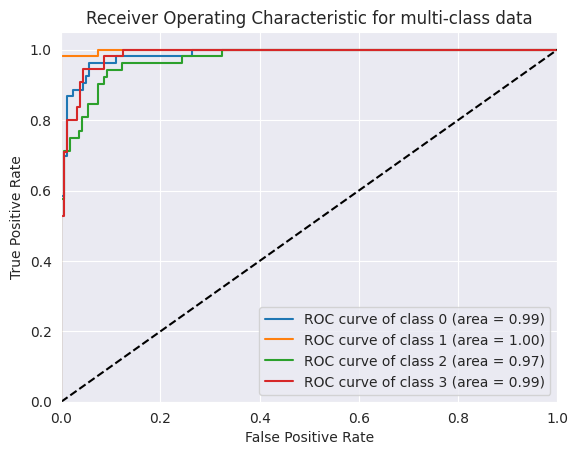

In [38]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [39]:
epoch = 20
batchsize = 32

In [40]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [41]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [42]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                           

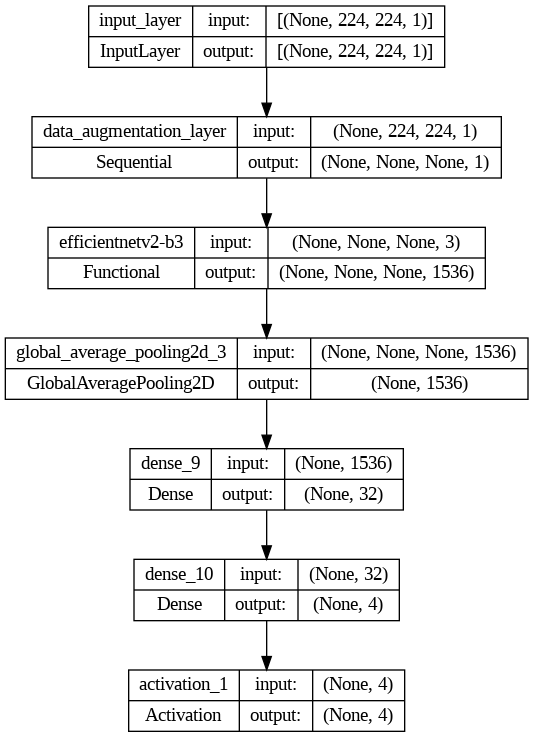

In [43]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [44]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [45]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 71s 503ms/step - loss: 0.6884 - accuracy: 0.7173 - val_loss: 0.7495 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 48s 401ms/step - loss: 0.5567 - accuracy: 0.7750 - val_loss: 0.6159 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 46s 380ms/step - loss: 0.5291 - accuracy: 0.7876 - val_loss: 0.6947 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 43s 358ms/step - loss: 0.4989 - accuracy: 0.8070 - val_loss: 0.6177 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 38s 316ms/step - loss: 0.4744 - accuracy: 0.8091 - val_loss: 0.4919 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 35s 288ms/step - loss: 0.4559 - accuracy: 0.8217 - val_loss: 0.6763 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

EfficientNetV2B3 Evaluation

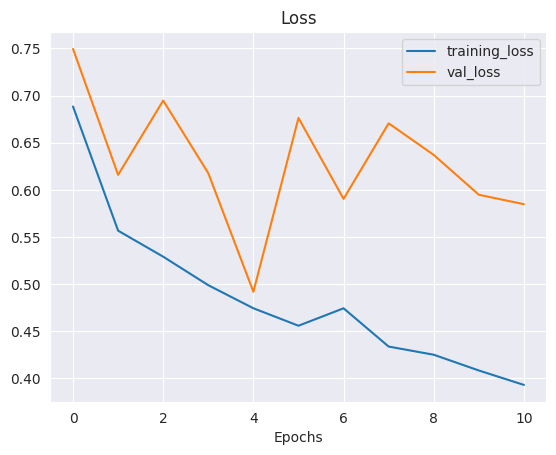

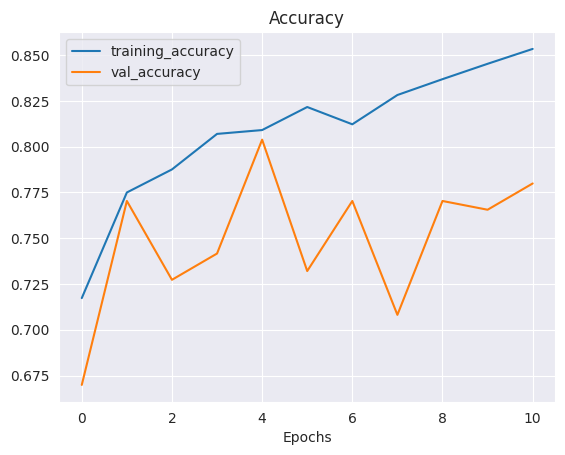

In [46]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 76ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        53
           1       0.81      0.91      0.86        56
           2       1.00      0.46      0.63        52
           3       0.63      0.85      0.72        55

    accuracy                           0.79       216
   macro avg       0.83      0.78      0.78       216
weighted avg       0.83      0.79      0.78       216

Specificity: [0.2857142857142857, 0.3090909090909091, 0.125, 0.2781065088757396]
Mean Squared Error: : 0.12965793907642365
The average AUC-ROC is 0.953440742038943


[0.9691358024691358,
 0.6535947712418301,
 0.7239583333333334,
 0.6595744680851063,
 0.654320987654321,
 0.9673202614379085,
 0.7083333333333334,
 0.6382978723404256,
 0.7098765432098766,
 0.6928104575163399,
 0.8541666666666666,
 0.7588652482269503,
 0.6666666666666666,
 0.6862745098039216,
 0.7135416666666666,
 0.9432624113475178]

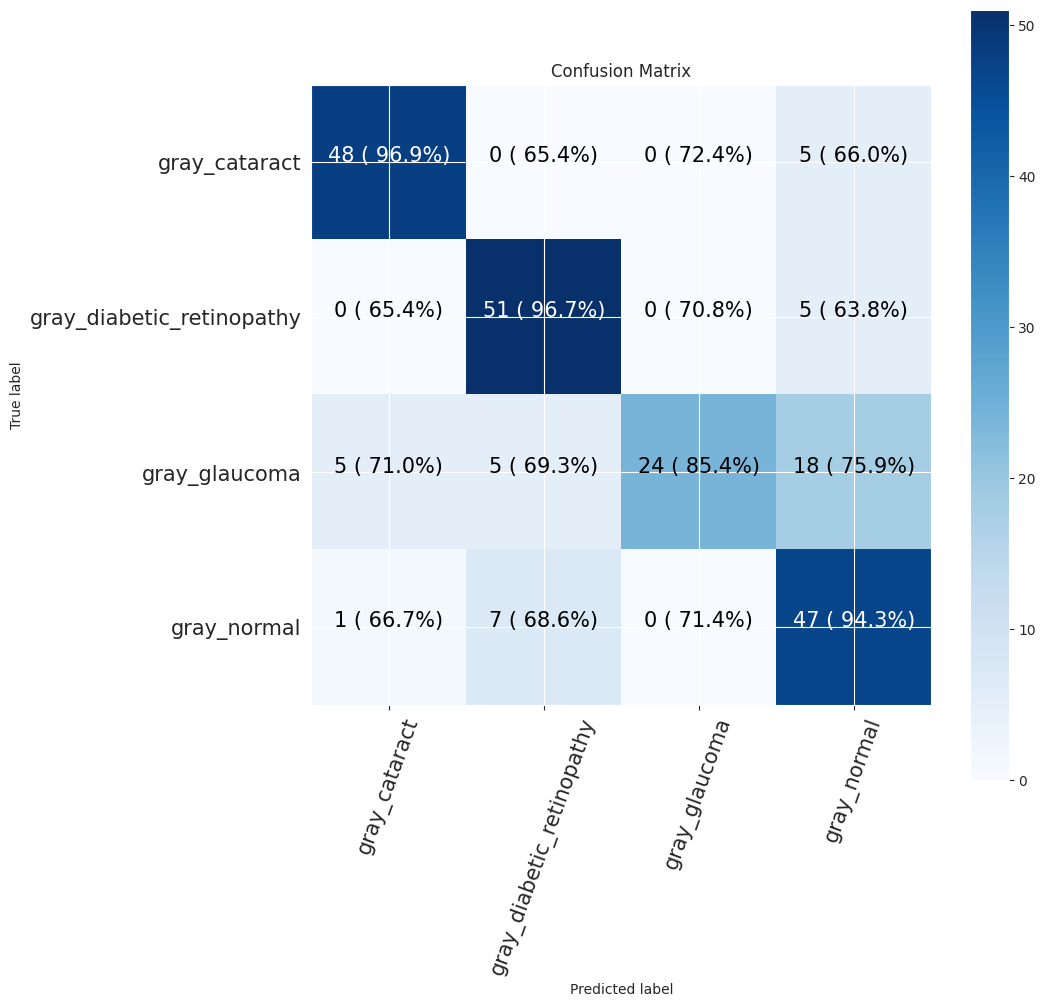

In [47]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


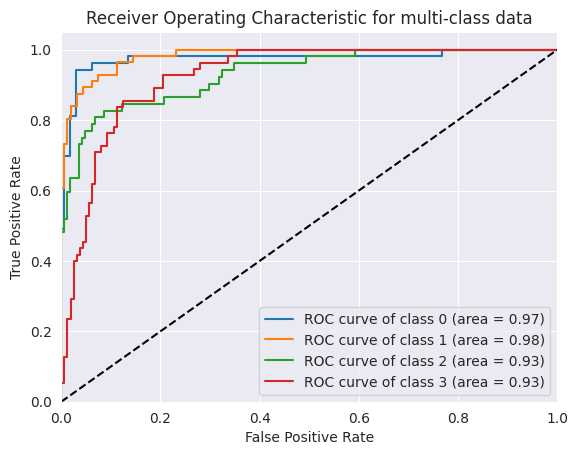

In [48]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [49]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

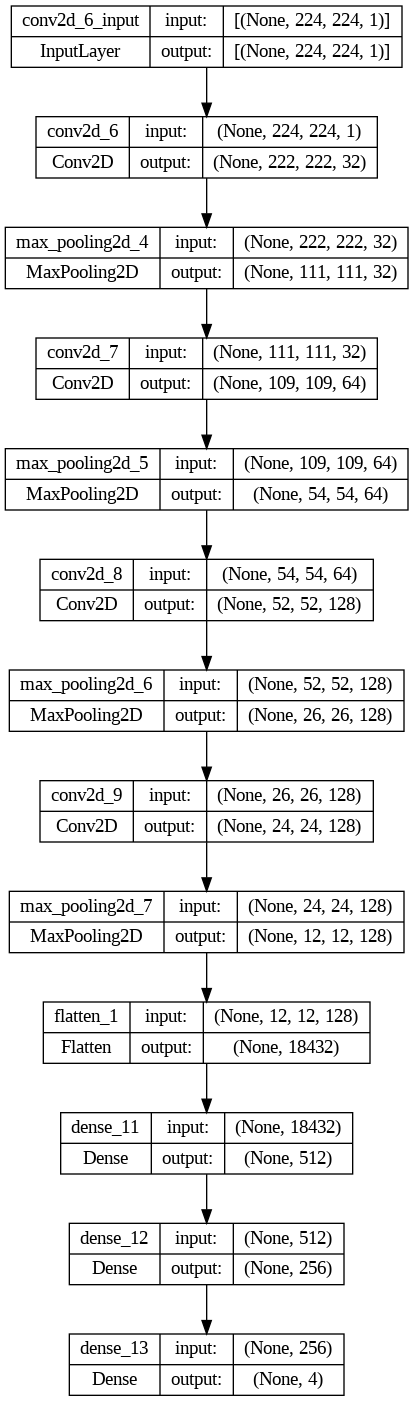

In [50]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [51]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [52]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 7s 36ms/step - loss: 3.1812 - accuracy: 0.5308 - val_loss: 0.7550 - val_accuracy: 0.6172 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 4s 34ms/step - loss: 0.6909 - accuracy: 0.6790 - val_loss: 0.6284 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 4s 34ms/step - loss: 0.6314 - accuracy: 0.7115 - val_loss: 0.6295 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 4s 34ms/step - loss: 0.6074 - accuracy: 0.7236 - val_loss: 0.6057 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 4s 34ms/step - loss: 0.5923 - accuracy: 0.7335 - val_loss: 0.5890 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 4s 34ms/step - loss: 0.5737 - accuracy: 0.7356 - val_loss: 0.5784 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 7/20
120/120 [==============================] - 4s 34ms/st

CNN Evaluation

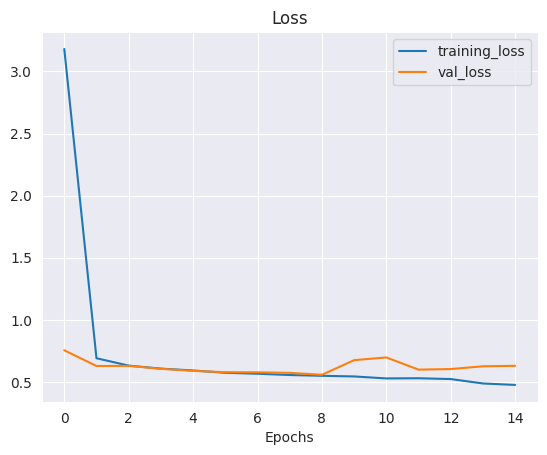

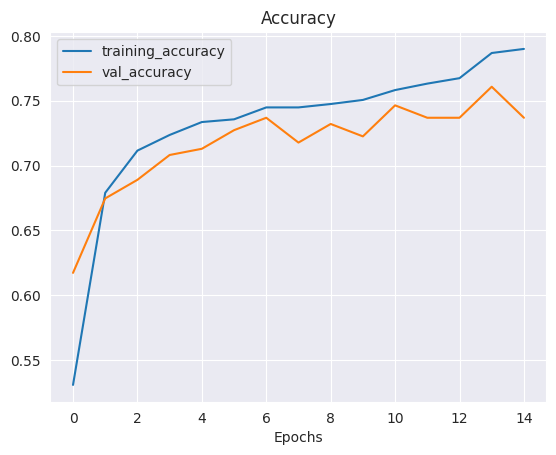

In [53]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 14ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.49      0.55        53
           1       1.00      1.00      1.00        56
           2       0.58      0.50      0.54        52
           3       0.70      0.95      0.81        55

    accuracy                           0.74       216
   macro avg       0.73      0.73      0.72       216
weighted avg       0.73      0.74      0.73       216

Specificity: [0.1368421052631579, 0.35, 0.1368421052631579, 0.3170731707317073]
Mean Squared Error: : 0.1345706433057785
The average AUC-ROC is 0.9184477274668049


[0.8457142857142858,
 0.66875,
 0.7953216374269005,
 0.6901408450704225,
 0.68,
 1.0,
 0.672514619883041,
 0.6056338028169014,
 0.7771428571428571,
 0.675,
 0.847953216374269,
 0.7253521126760564,
 0.6971428571428572,
 0.65625,
 0.6842105263157895,
 0.9788732394366197]

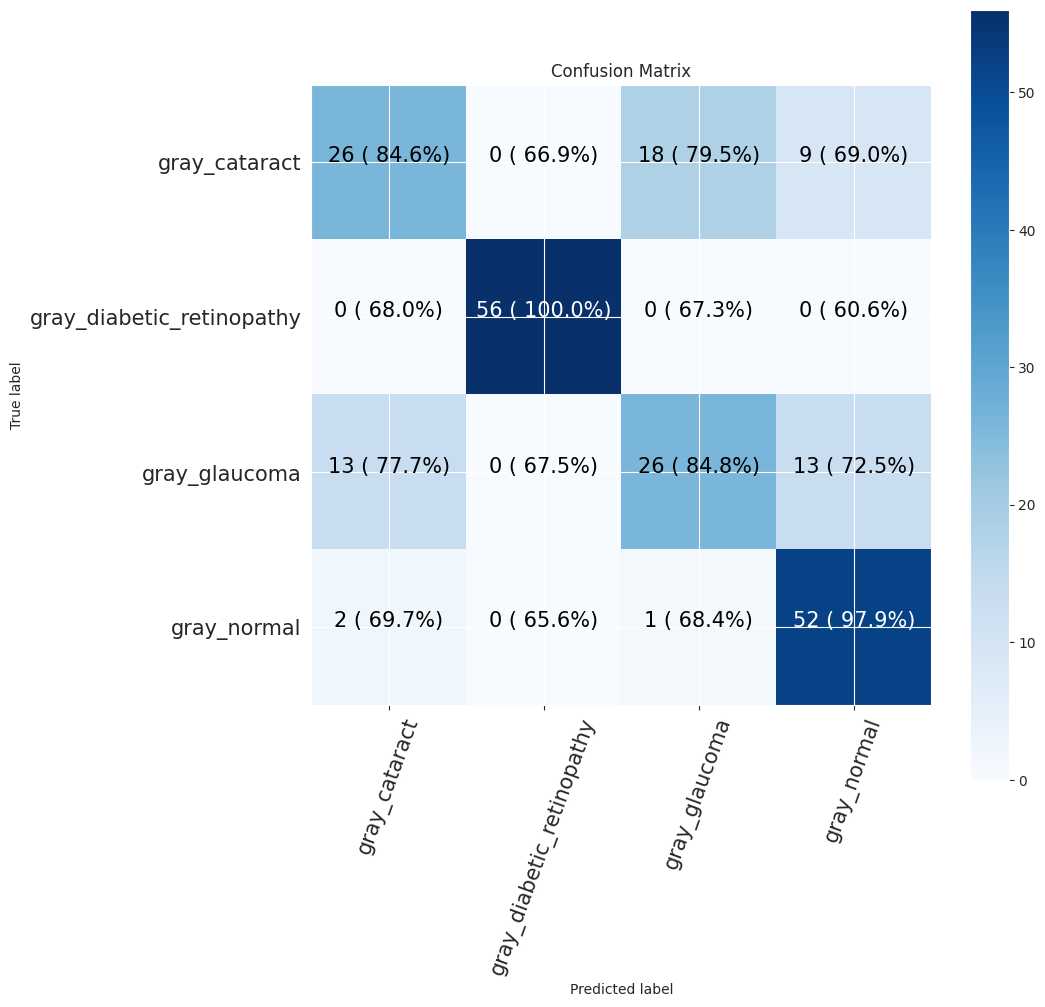

In [54]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


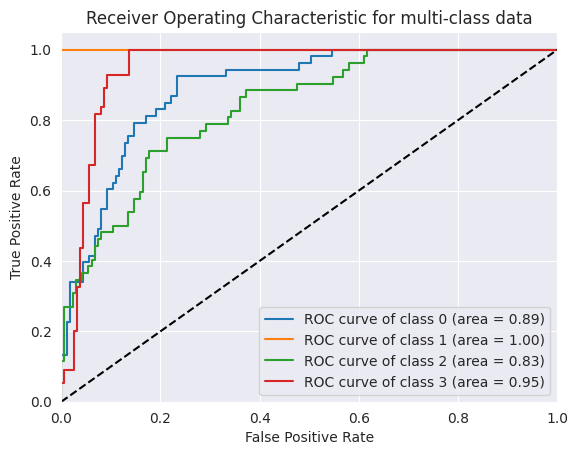

In [55]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [56]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_15 (Dense)            (None, 4)                 4100      
                                                           

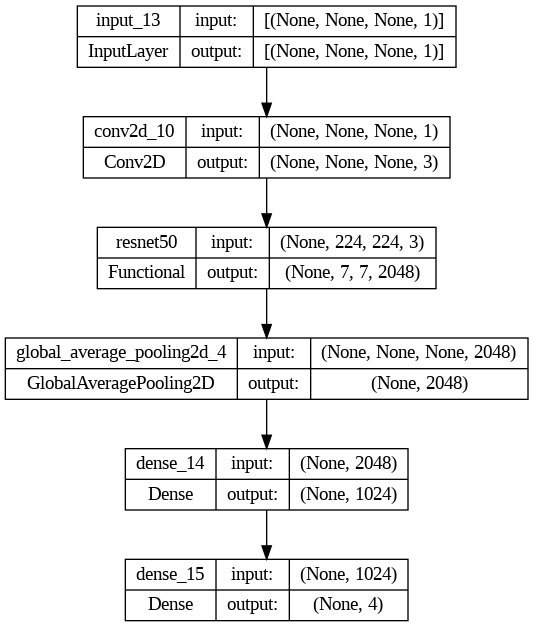

In [57]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [58]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [59]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 37s 265ms/step - loss: 0.6218 - accuracy: 0.7792 - val_loss: 0.4222 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 30s 251ms/step - loss: 0.3537 - accuracy: 0.8655 - val_loss: 0.3068 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 30s 250ms/step - loss: 0.2835 - accuracy: 0.8888 - val_loss: 0.2814 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 30s 251ms/step - loss: 0.2482 - accuracy: 0.9064 - val_loss: 0.3168 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 30s 251ms/step - loss: 0.2478 - accuracy: 0.9001 - val_loss: 0.3017 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 30s 250ms/step - loss: 0.2372 - accuracy: 0.9090 - val_loss: 0.2588 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet50 Evaluation

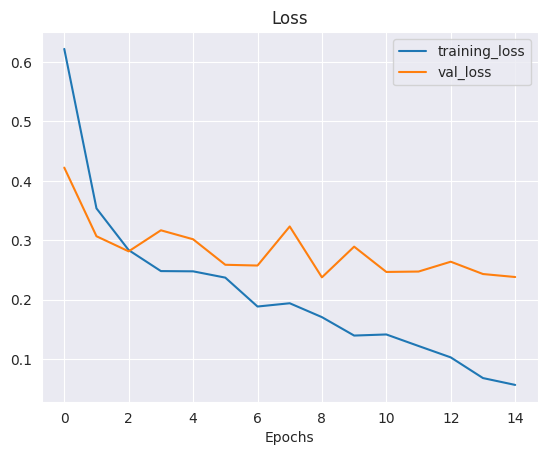

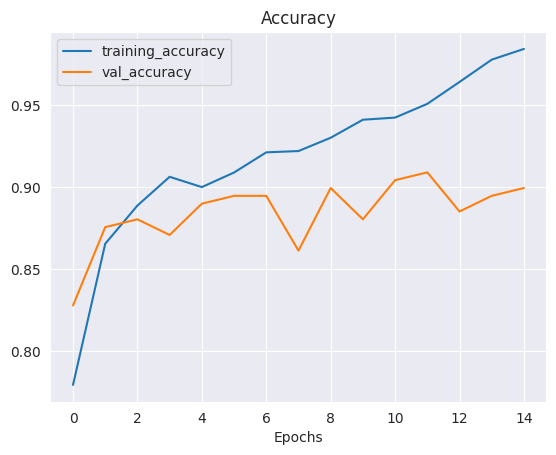

In [60]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 92ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88        53
           1       0.98      1.00      0.99        56
           2       0.86      0.85      0.85        52
           3       0.88      0.89      0.88        55

    accuracy                           0.90       216
   macro avg       0.90      0.90      0.90       216
weighted avg       0.90      0.90      0.90       216

Specificity: [0.27058823529411763, 0.35, 0.2558139534883721, 0.2934131736526946]
Mean Squared Error: : 0.1077708974480629
The average AUC-ROC is 0.9854042229231862


[0.9573170731707317,
 0.6666666666666666,
 0.696969696969697,
 0.69375,
 0.6585365853658537,
 1.0,
 0.6606060606060606,
 0.65,
 0.7073170731707317,
 0.6792452830188679,
 0.9515151515151515,
 0.69375,
 0.676829268292683,
 0.6540880503144654,
 0.6909090909090909,
 0.9625]

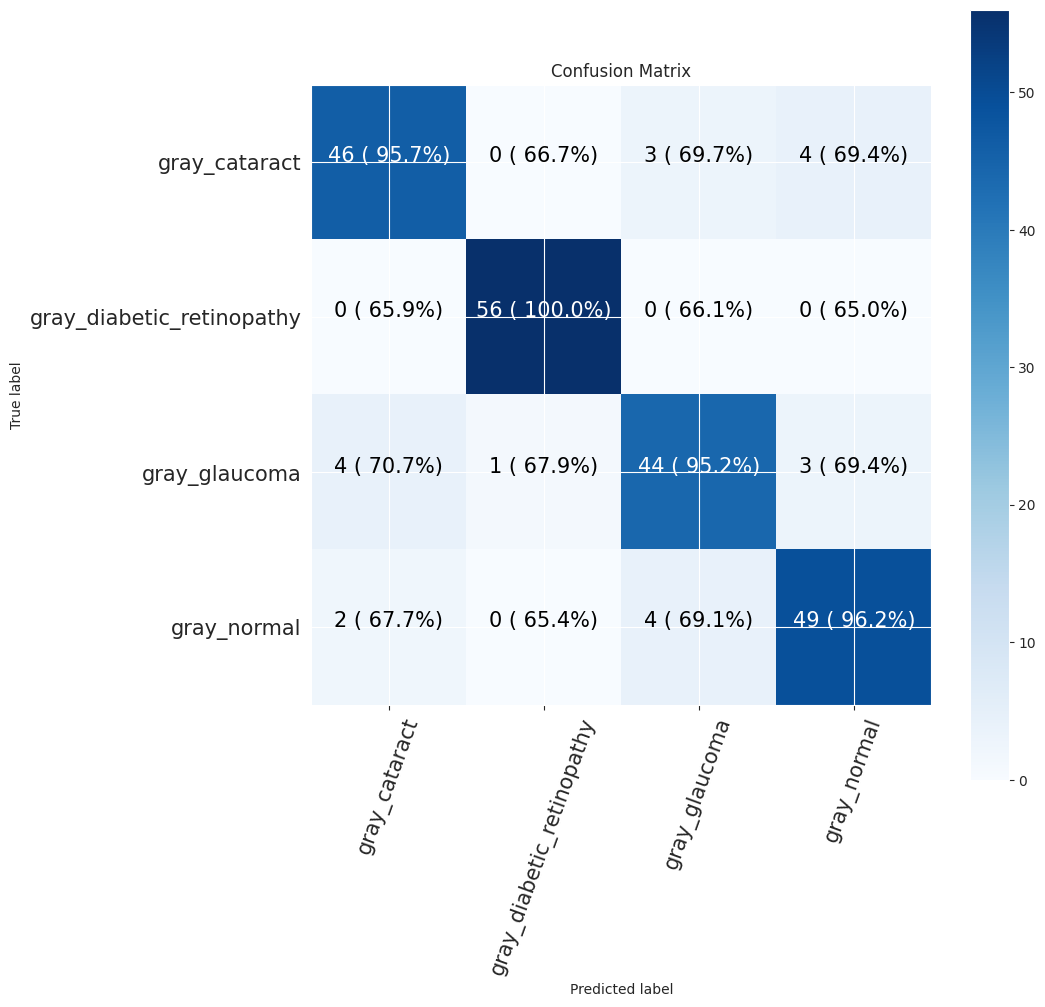

In [61]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


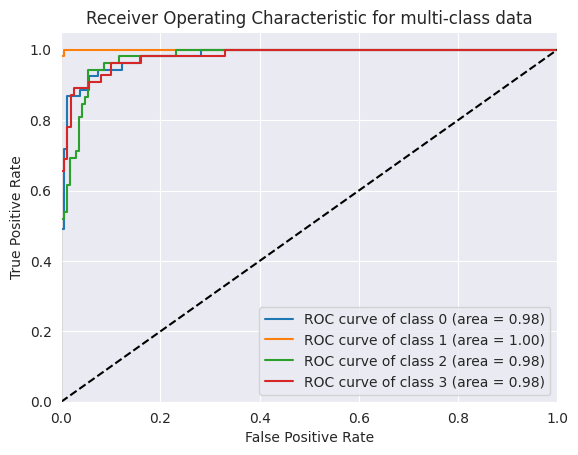

In [62]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [63]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_17 (Dense)            (None, 4)                 4100      
                                                           

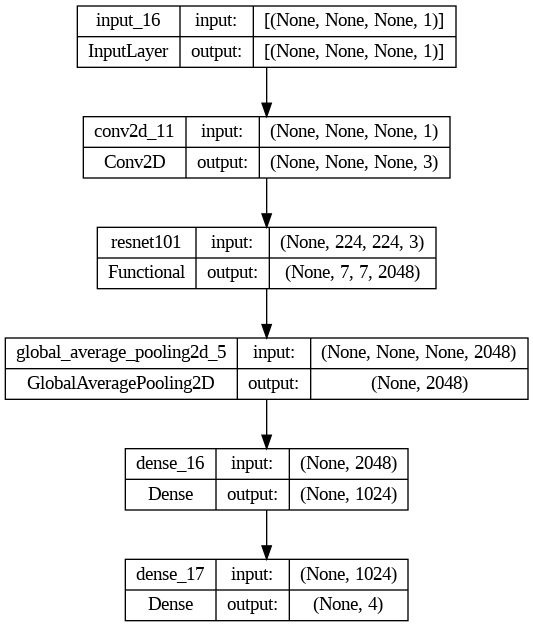

In [64]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [65]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [66]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 58s 432ms/step - loss: 0.6936 - accuracy: 0.7616 - val_loss: 0.4553 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 49s 412ms/step - loss: 0.3830 - accuracy: 0.8497 - val_loss: 0.5030 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 50s 414ms/step - loss: 0.3240 - accuracy: 0.8773 - val_loss: 0.4836 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 50s 413ms/step - loss: 0.2834 - accuracy: 0.8906 - val_loss: 0.3637 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 50s 414ms/step - loss: 0.2463 - accuracy: 0.9045 - val_loss: 0.3421 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 50s 414ms/step - loss: 0.2605 - accuracy: 0.8988 - val_loss: 0.3720 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet101 Evaluation

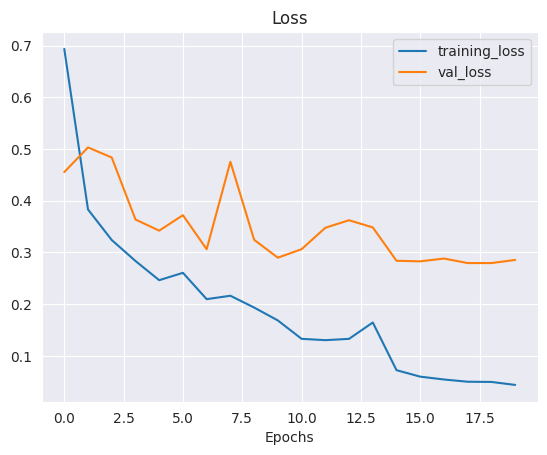

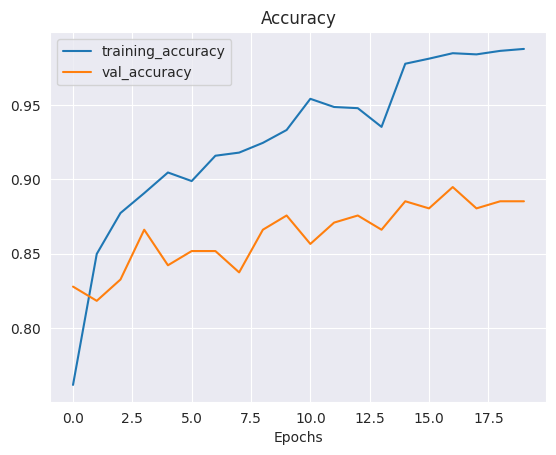

In [67]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 156ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94        53
           1       1.00      1.00      1.00        56
           2       0.93      0.77      0.84        52
           3       0.85      0.95      0.90        55

    accuracy                           0.92       216
   macro avg       0.92      0.92      0.92       216
weighted avg       0.92      0.92      0.92       216

Specificity: [0.3090909090909091, 0.35, 0.22727272727272727, 0.3170731707317073]
Mean Squared Error: : 0.10407821834087372
The average AUC-ROC is 0.9905920892308652


[0.9875,
 0.66875,
 0.6994219653179191,
 0.6645161290322581,
 0.65,
 1.0,
 0.6763005780346821,
 0.6387096774193548,
 0.7,
 0.675,
 0.930635838150289,
 0.7161290322580646,
 0.6625,
 0.65625,
 0.6936416184971098,
 0.9806451612903225]

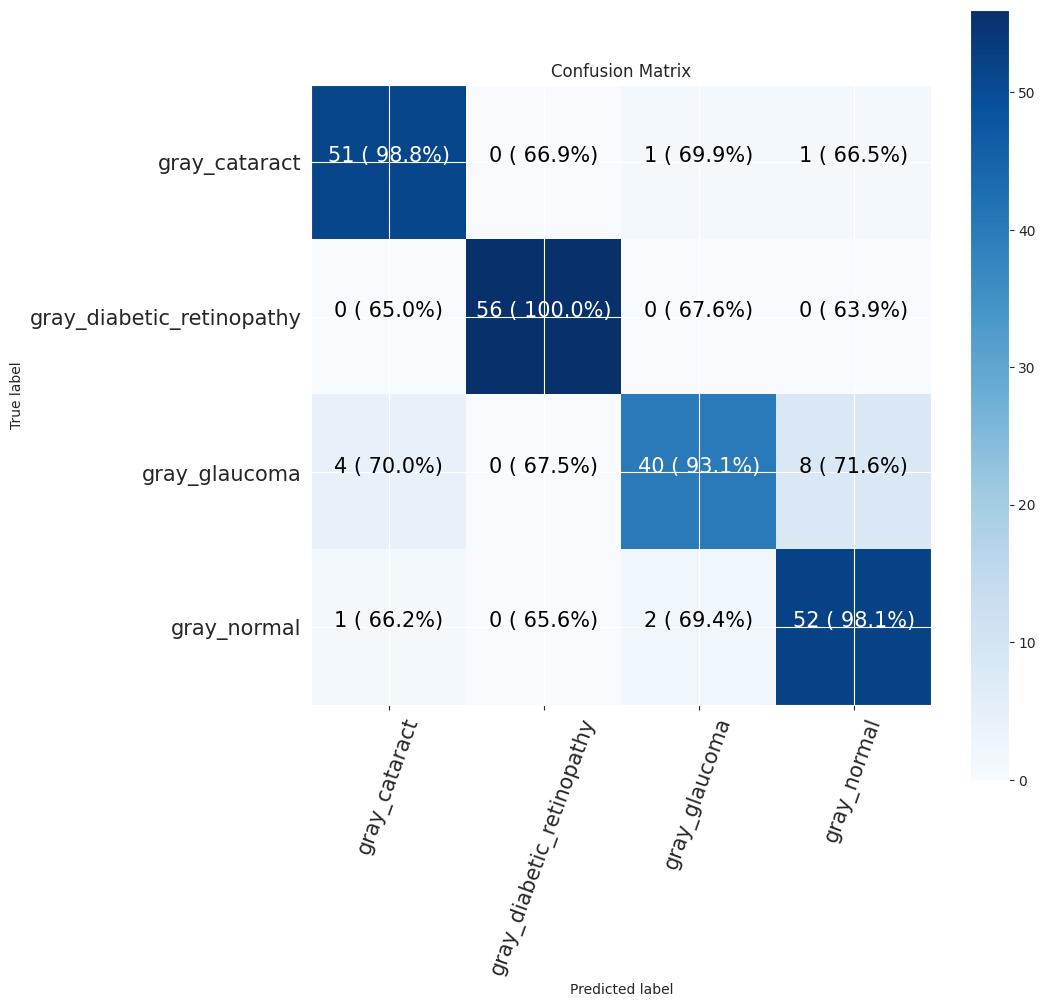

In [68]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


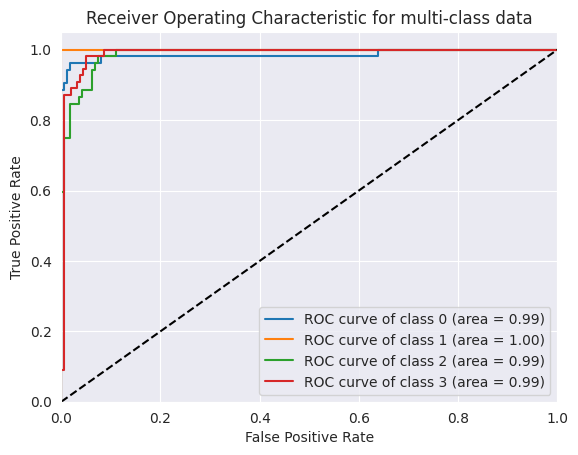

In [69]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [70]:
epoch = 20
batchsize = 64

In [71]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [72]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [73]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_6  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 32)                49184     
                                                           

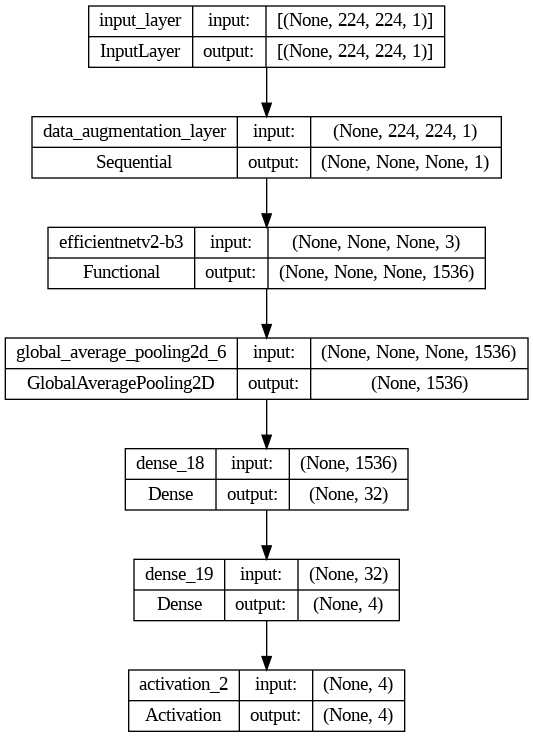

In [74]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [75]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [76]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 69s 970ms/step - loss: 0.8165 - accuracy: 0.6577 - val_loss: 0.7177 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 47s 769ms/step - loss: 0.5999 - accuracy: 0.7632 - val_loss: 0.6264 - val_accuracy: 0.7464 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 47s 771ms/step - loss: 0.5594 - accuracy: 0.7779 - val_loss: 0.6476 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 43s 720ms/step - loss: 0.5263 - accuracy: 0.7923 - val_loss: 0.5977 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 42s 695ms/step - loss: 0.5100 - accuracy: 0.8033 - val_loss: 0.5580 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 40s 653ms/step - loss: 0.4974 - accuracy: 0.8023 - val_loss: 0.5423 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 40s 650ms/st

EfficientNetV2B3 Evaluation

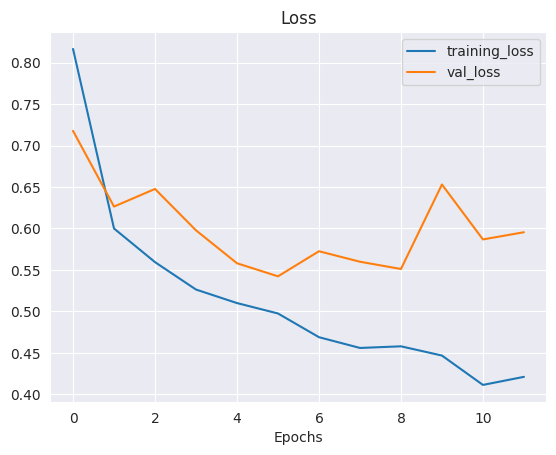

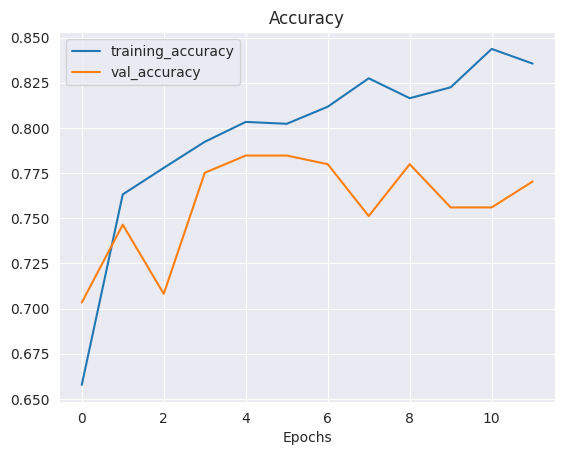

In [77]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 145ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        53
           1       0.85      0.89      0.87        56
           2       1.00      0.46      0.63        52
           3       0.64      0.87      0.74        55

    accuracy                           0.80       216
   macro avg       0.84      0.79      0.79       216
weighted avg       0.83      0.80      0.79       216

Specificity: [0.30120481927710846, 0.30120481927710846, 0.125, 0.2857142857142857]
Mean Squared Error: : 0.12944915890693665
The average AUC-ROC is 0.9559865502547165


[0.9810126582278481,
 0.6624203821656051,
 0.7239583333333334,
 0.6453900709219859,
 0.6455696202531646,
 0.9617834394904459,
 0.7083333333333334,
 0.6453900709219859,
 0.7151898734177216,
 0.6878980891719745,
 0.8541666666666666,
 0.7588652482269503,
 0.6582278481012658,
 0.6878980891719745,
 0.7135416666666666,
 0.950354609929078]

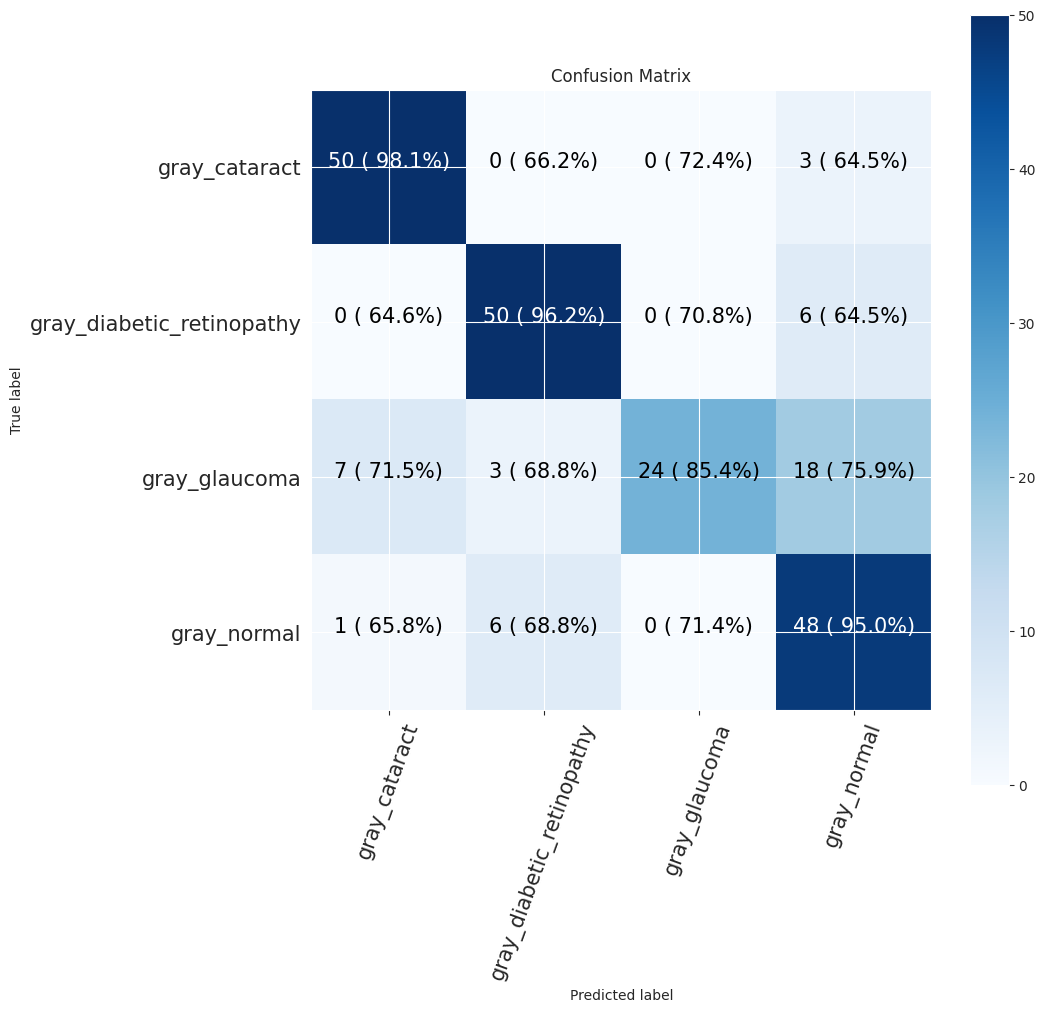

In [78]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


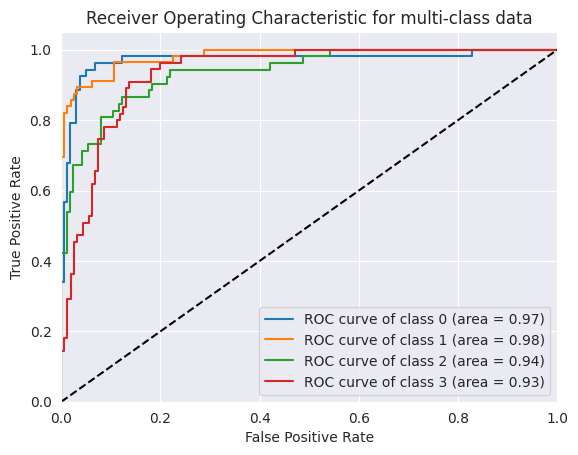

In [79]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [80]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

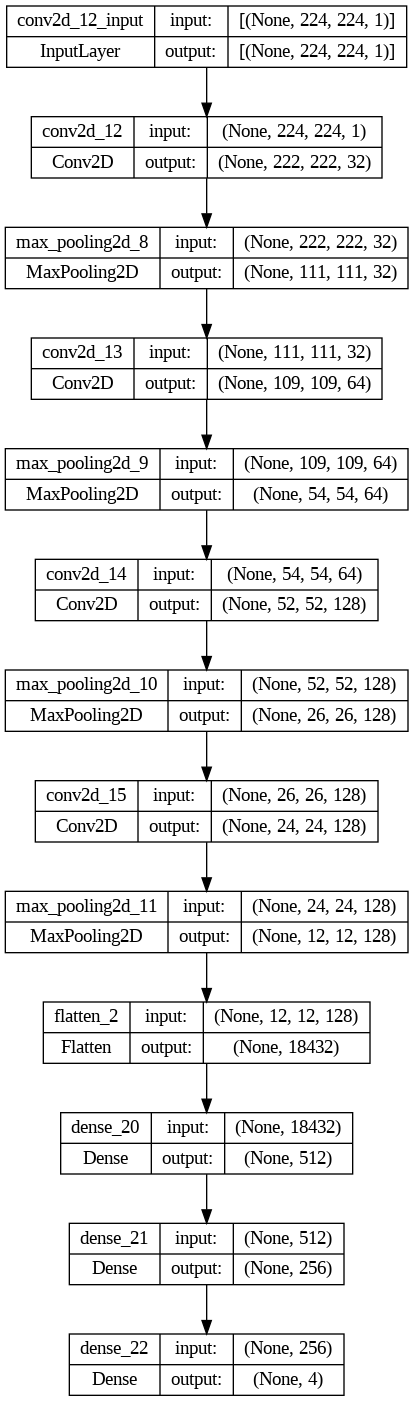

In [81]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [82]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [83]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 7s 76ms/step - loss: 6.1153 - accuracy: 0.5222 - val_loss: 0.7781 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 4s 62ms/step - loss: 0.6535 - accuracy: 0.7231 - val_loss: 0.6050 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 4s 63ms/step - loss: 0.5471 - accuracy: 0.7671 - val_loss: 0.6951 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 4s 62ms/step - loss: 0.5576 - accuracy: 0.7739 - val_loss: 0.4849 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 4s 63ms/step - loss: 0.4756 - accuracy: 0.7973 - val_loss: 0.4596 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 4s 63ms/step - loss: 0.4361 - accuracy: 0.8141 - val_loss: 0.4279 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 4s 63ms/step - loss: 0.4

CNN Evaluation

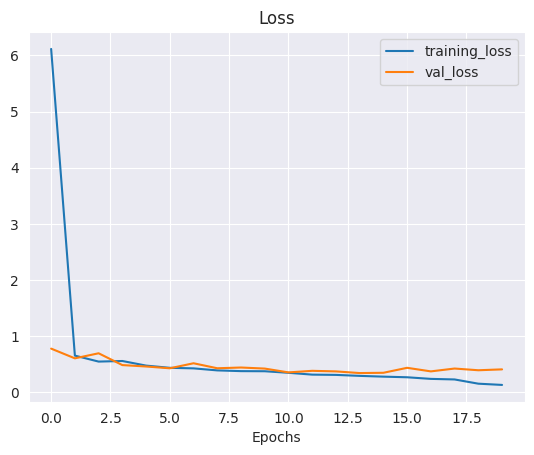

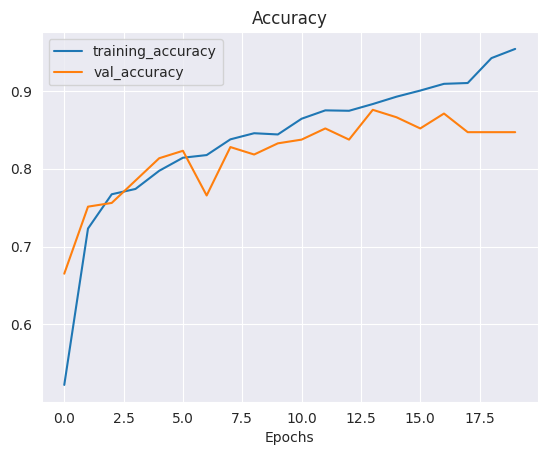

In [84]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        53
           1       1.00      0.98      0.99        56
           2       0.76      0.71      0.73        52
           3       0.79      0.76      0.78        55

    accuracy                           0.84       216
   macro avg       0.84      0.84      0.84       216
weighted avg       0.84      0.84      0.84       216

Specificity: [0.2781065088757396, 0.3416149068322981, 0.20670391061452514, 0.2413793103448276]
Mean Squared Error: : 0.1187189370393753
The average AUC-ROC is 0.9581423703541926


[0.9617834394904459,
 0.6708074534161491,
 0.7065868263473054,
 0.6871165644171779,
 0.643312101910828,
 0.9937888198757764,
 0.6646706586826348,
 0.6625766871165644,
 0.7133757961783439,
 0.6770186335403726,
 0.9101796407185628,
 0.7300613496932515,
 0.6815286624203821,
 0.6583850931677019,
 0.718562874251497,
 0.9202453987730062]

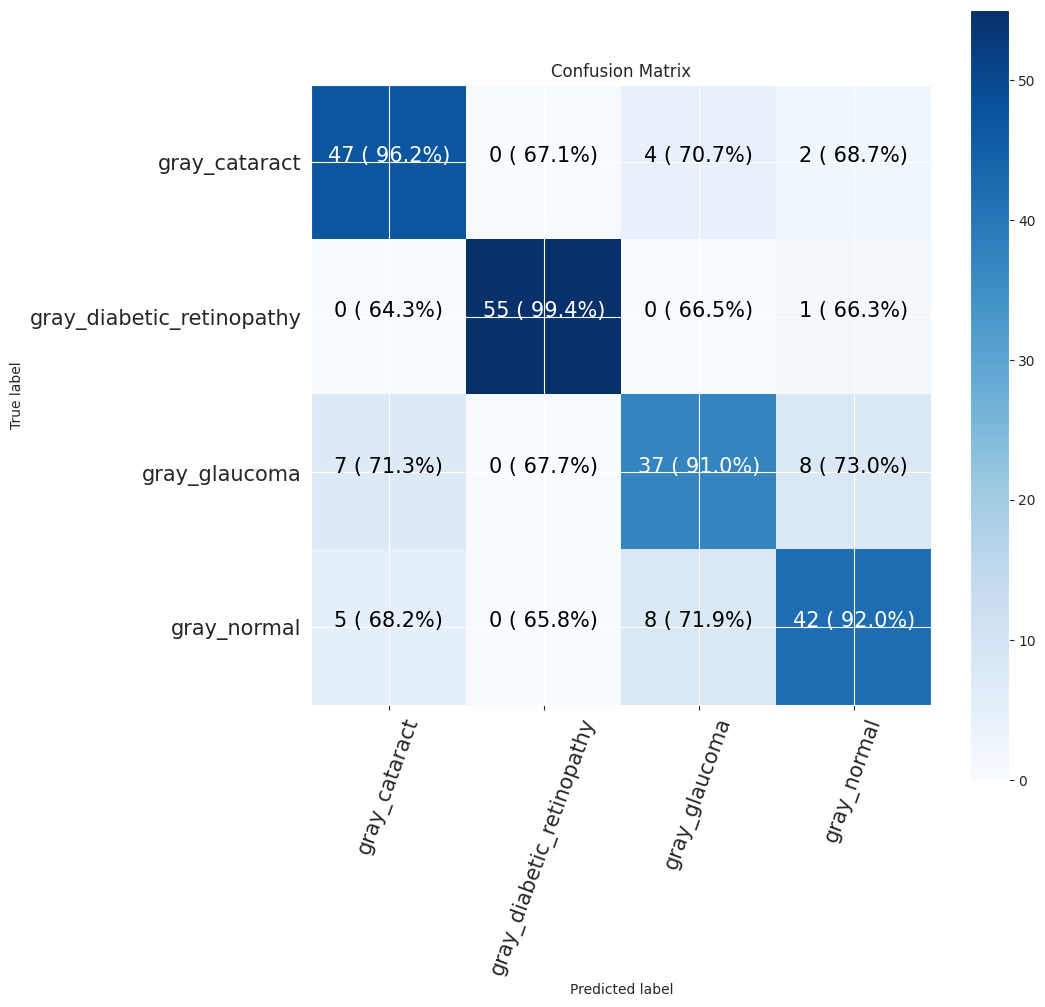

In [85]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


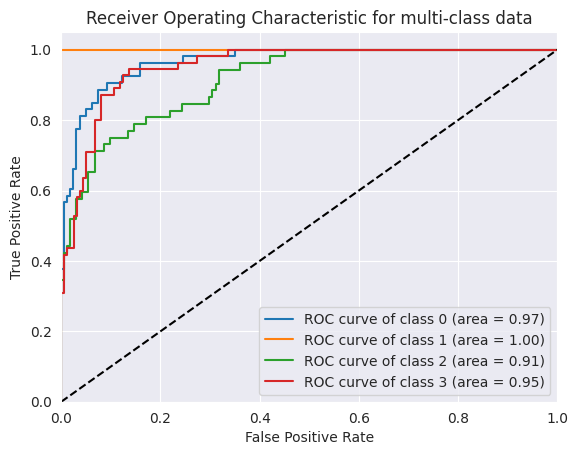

In [86]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [87]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_24 (Dense)            (None, 4)                 4100      
                                                           

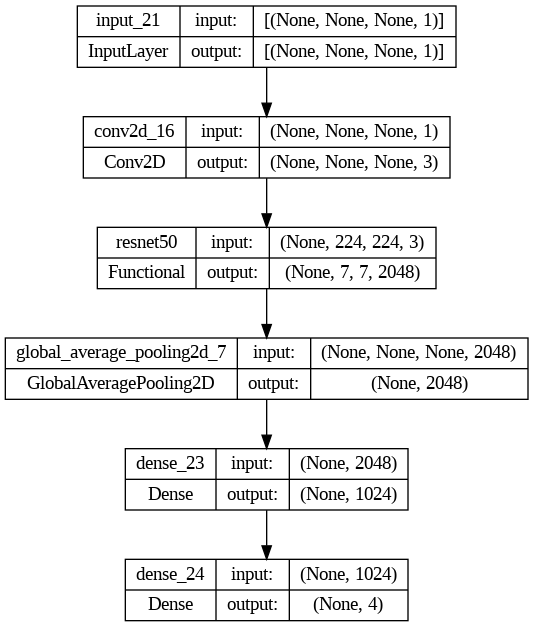

In [88]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [89]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [90]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 40s 545ms/step - loss: 0.6754 - accuracy: 0.7600 - val_loss: 0.3797 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 29s 484ms/step - loss: 0.3625 - accuracy: 0.8589 - val_loss: 0.3077 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 29s 484ms/step - loss: 0.3230 - accuracy: 0.8704 - val_loss: 0.2607 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 29s 487ms/step - loss: 0.2443 - accuracy: 0.9048 - val_loss: 0.2712 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 29s 485ms/step - loss: 0.2044 - accuracy: 0.9229 - val_loss: 0.3548 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 29s 484ms/step - loss: 0.2021 - accuracy: 0.9229 - val_loss: 0.3293 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 29s 486ms/st

ResNet50 Evaluation

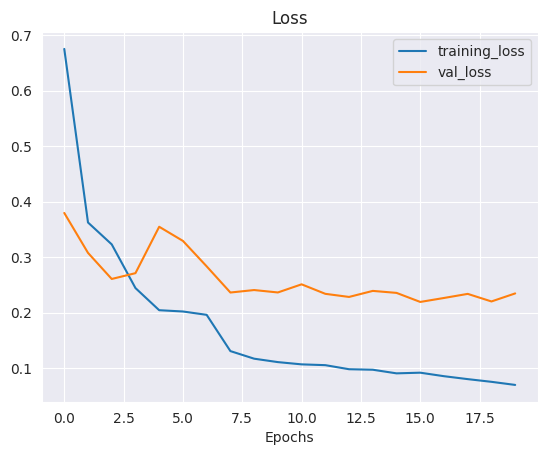

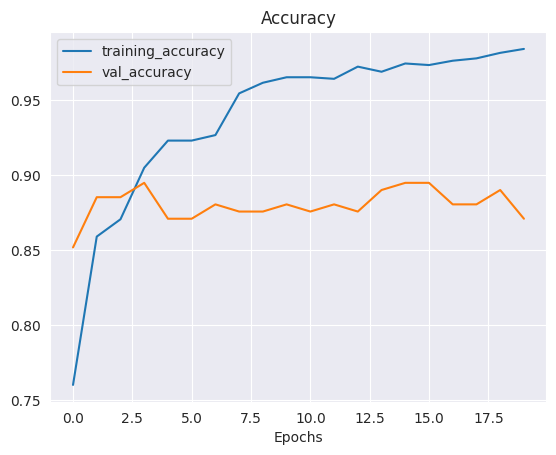

In [91]:
plot_loss_curves(resnet50_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 175ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        53
           1       1.00      1.00      1.00        56
           2       0.91      0.81      0.86        52
           3       0.89      0.98      0.93        55

    accuracy                           0.93       216
   macro avg       0.93      0.92      0.92       216
weighted avg       0.93      0.93      0.92       216

Specificity: [0.2857142857142857, 0.35, 0.2413793103448276, 0.3333333333333333]
Mean Squared Error: : 0.10547729581594467
The average AUC-ROC is 0.9914586377393955


[0.9693251533742331,
 0.66875,
 0.711764705882353,
 0.6645161290322581,
 0.656441717791411,
 1.0,
 0.6705882352941176,
 0.6387096774193548,
 0.7055214723926381,
 0.675,
 0.9411764705882353,
 0.7032258064516129,
 0.6687116564417178,
 0.65625,
 0.6764705882352942,
 0.9935483870967742]

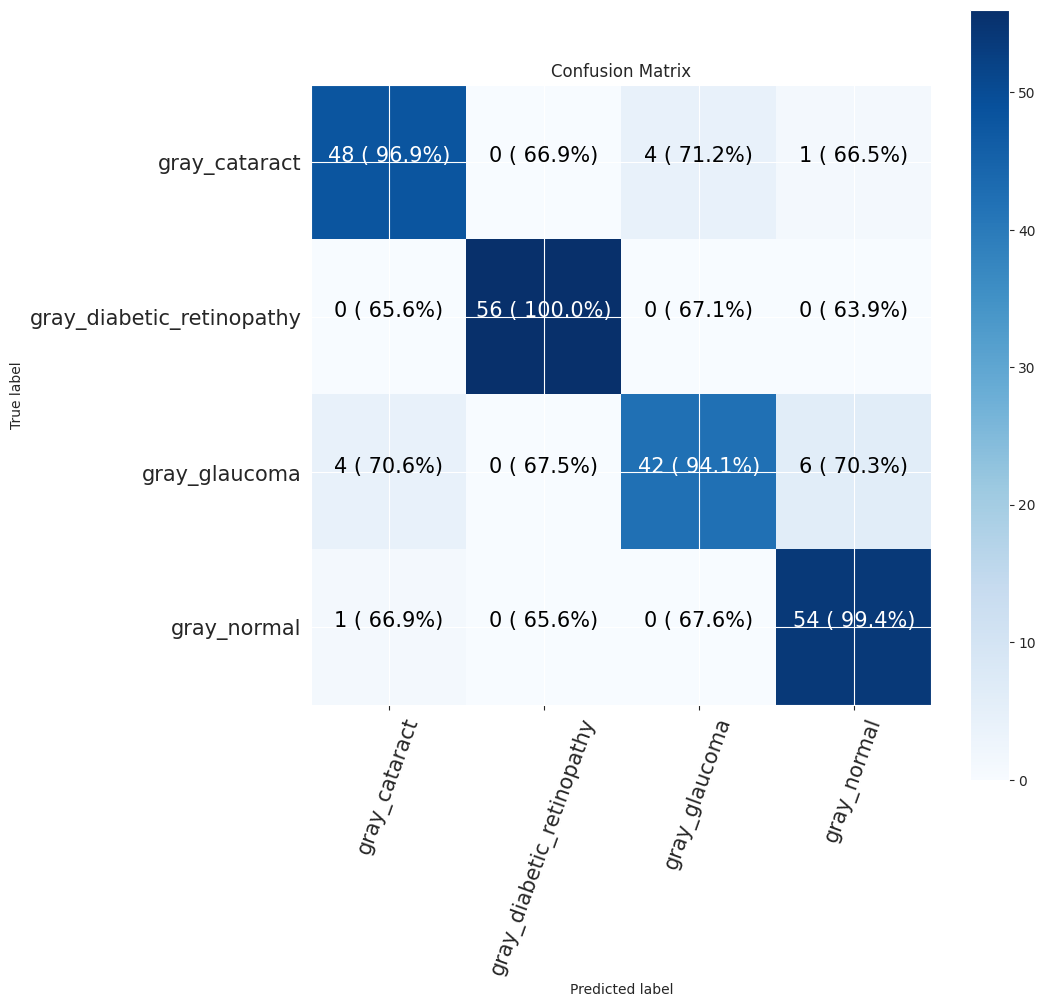

In [92]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


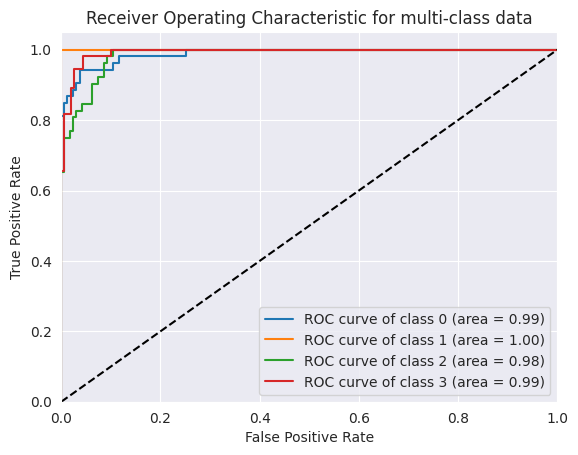

In [93]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [94]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_26 (Dense)            (None, 4)                 4100      
                                                           

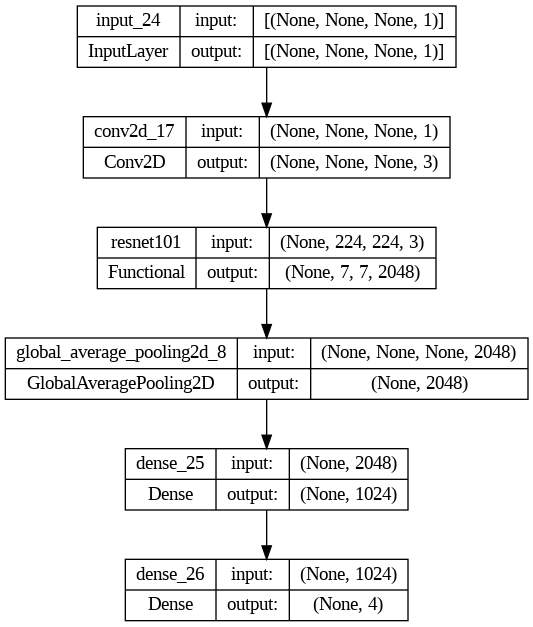

In [95]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [96]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [97]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 57s 828ms/step - loss: 1.1134 - accuracy: 0.6706 - val_loss: 0.5479 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 47s 785ms/step - loss: 0.4536 - accuracy: 0.8235 - val_loss: 0.4226 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 48s 790ms/step - loss: 0.3847 - accuracy: 0.8534 - val_loss: 0.4006 - val_accuracy: 0.8325 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 47s 788ms/step - loss: 0.3443 - accuracy: 0.8657 - val_loss: 0.3740 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 48s 790ms/step - loss: 0.3359 - accuracy: 0.8621 - val_loss: 0.4021 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 47s 788ms/step - loss: 0.2918 - accuracy: 0.8830 - val_loss: 0.3754 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 47s 788ms/st

ResNet101 Evaluation

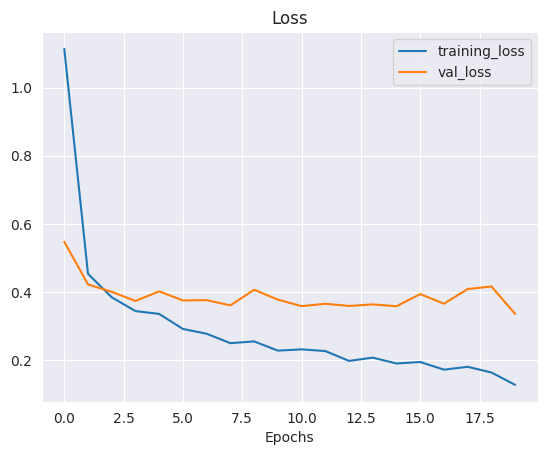

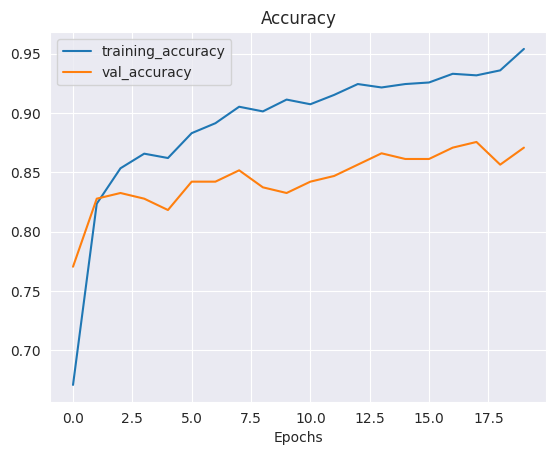

In [98]:
plot_loss_curves(resnet101_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 298ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        53
           1       0.98      0.98      0.98        56
           2       0.84      0.69      0.76        52
           3       0.86      0.87      0.86        55

    accuracy                           0.88       216
   macro avg       0.87      0.87      0.87       216
weighted avg       0.88      0.88      0.87       216

Specificity: [0.30120481927710846, 0.3416149068322981, 0.2, 0.2857142857142857]
Mean Squared Error: : 0.11041970551013947
The average AUC-ROC is 0.9825905734024478


[0.9806451612903225,
 0.66875,
 0.7052023121387283,
 0.675,
 0.6387096774193548,
 0.99375,
 0.6763005780346821,
 0.65625,
 0.7290322580645161,
 0.675,
 0.9075144508670521,
 0.7125,
 0.6516129032258065,
 0.6625,
 0.7109826589595376,
 0.95625]

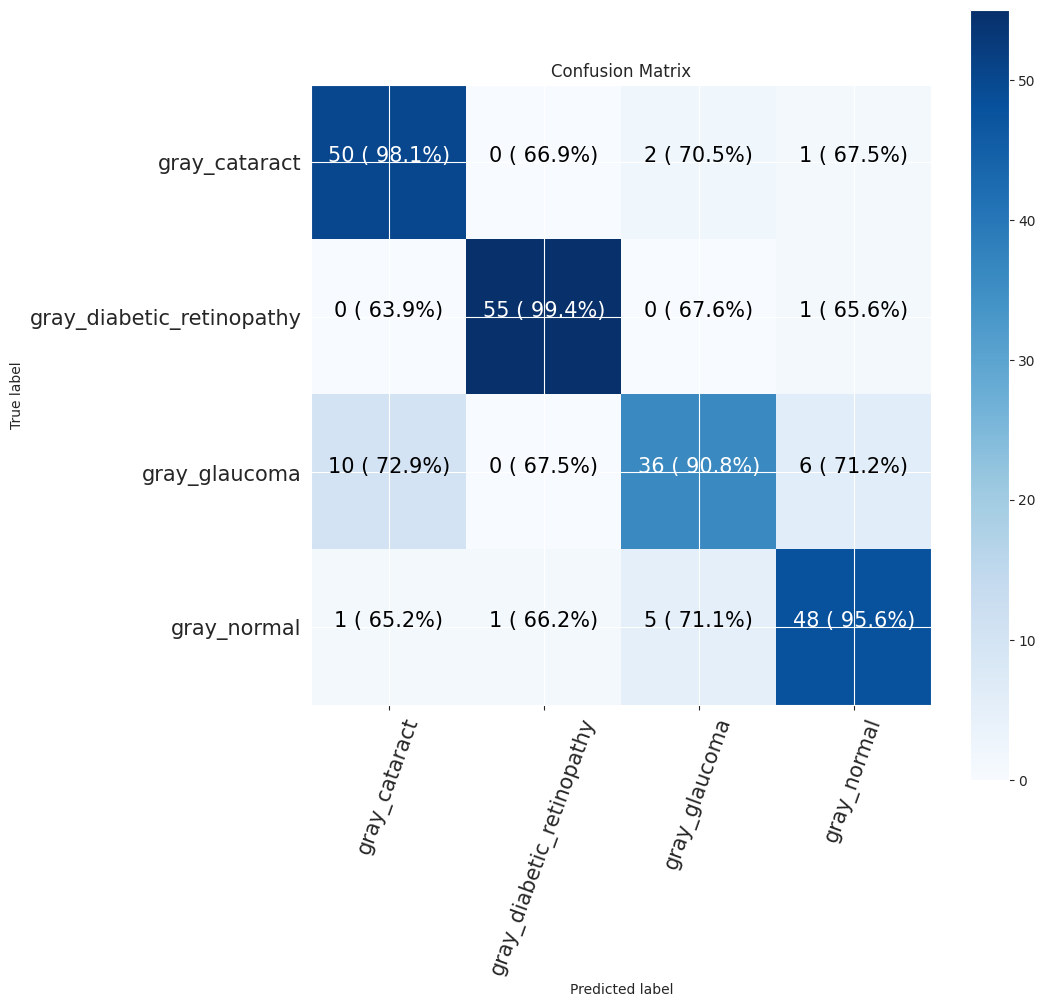

In [99]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


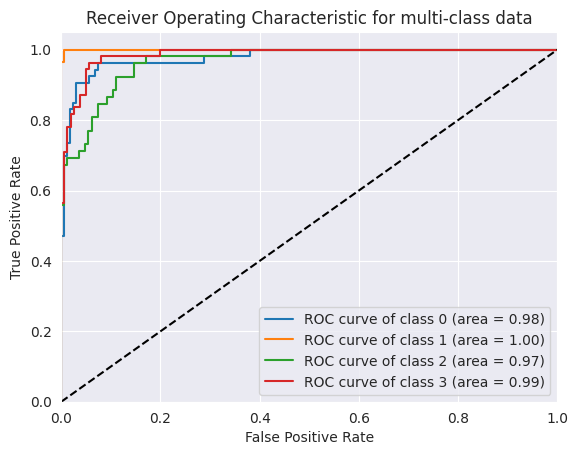

In [100]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()